In [73]:
from numpy.random import randn
import numpy as np
import copy
class Human(object):
    def __init__(self, pos=(0, 0, 0), vel=(0, 0, 0), noise_std=1.):
        self.vel = [vel[0], vel[1], vel[2]]
        self.noise_std = noise_std
        self.pos = [pos[0], pos[1], pos[2]]
        
    def update(self,dt):
        self.vel[0] += randn() * self.noise_std
        self.vel[1] += randn() * self.noise_std
        self.vel[2] += randn() * self.noise_std
        self.pos[0] += dt*self.vel[0]
        self.pos[1] += dt*self.vel[1]
        self.pos[2] += dt*self.vel[2]
        
        dt=0.1*abs(randn()) * self.noise_std

        return [self.pos[0],
                self.pos[1],
                (self.pos[2] + np.pi) % (2 * np.pi) - np.pi], dt

100
(100, 6, 1)


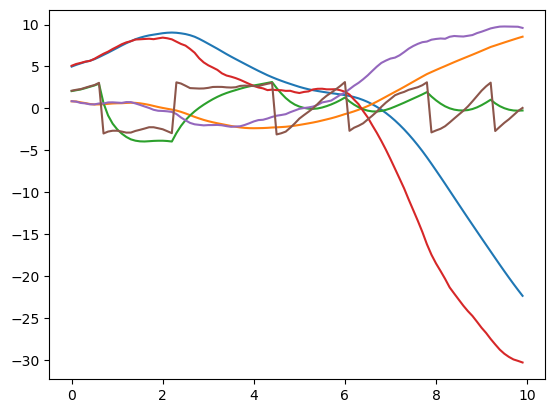

In [74]:
from filterpy.kalman import KalmanFilter
import numpy as np
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise
import matplotlib.pyplot as plt
import numpy as np

class personTracker(KalmanFilter):
    def __init__(self,dt, init_pos,dim_x=6, dim_z=3):
        
        # state= x y theta dotx doty dottheta
        # measurements = x,y,theta
        super().__init__(dim_x=6,dim_z=3)
        self.generateMatricies(dt)
        self.u = 0.
        self.H = np.array([[1, 0, 0, 0, 0, 0],
                            [0, 1, 0, 0, 0, 0],
                            [0, 0, 1, 0, 0, 0]])
        self.R = np.eye(self.dim_z) * 10
        self.x = np.array([[init_pos[0],init_pos[1],init_pos[2], 0, 0, 0]]).T
        self.P = np.eye(self.dim_x) * 500.

    def generateMatricies(self, dt):
        #so the kalman filter can adjust to the rate
        self.F = np.array([ [1,  0, 0,  dt,   0,  0],
                            [0,  1, 0,   0,  dt,  0],
                            [0,  0, 1,   0,   0, dt],
                            [0,  0, 0,   1,   0,  0],
                            [0,  0, 0,   0,   1,  0],
                            [0,  0, 0,   0,   0,  1]])
        q = Q_discrete_white_noise(dim=self.dim_z, dt=dt, var=0.05)
        self.Q = block_diag(q, q)



def sense(x, noise_scale=1.):
    return x[0] + randn()*noise_scale


# simulate robot movement
dt = 0.1   # time step 0.1 second
N = 100
initialMeasurement=[5,1,2]
human = Human (initialMeasurement, (0.7, 1, 0.5), 1.)

# run filter
person_tracker = personTracker(dt,[0,0,0])
xs,zs, time= [],[],[]
for i in range(N):
    person_tracker.predict()
    measurement,dt=human.update(dt)
    person_tracker.generateMatricies(dt)
    person_tracker.update(measurement)
    xs.append(person_tracker.x)

    if i == 0:
        time.append(0)
    else:
        time.append(time[-1]+dt)
    zs.append(measurement)
    # print(person_tracker.x)
print(len(xs))
resx=np.array(xs)
resz=np.array(zs)
print(resx.shape)
# plot results

plt.plot(time, resx[:, 0])
plt.plot(time, resx[:, 1])
plt.plot(time, resx[:, 2])
plt.plot(time, resz[:, 0])
plt.plot(time, resz[:, 1])
plt.plot(time, resz[:, 2])

# plt.plot(lins)
# plt.legend(loc=2)
# plt.gca().set_aspect('equal')
# plt.xlim((0, 20))
